# LangGraph

## 사전 준비 : 가상환경 구축 및 패키지 설치

In [1]:
#1

!pip uninstall -y google-generativeai
!pip install langchain==0.3.24 langchain_core==0.3.55 langchain_google_genai==2.1.3 httpx==0.28.1 requests==2.32.3 langchain-tavily==0.1.5 langgraph==0.3.31

Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing in

## Tool Calling을 이용한 AI 에이전트 구현 방법

In [2]:
# 2

import os
import time
import operator
import uuid
from typing import  Annotated
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_tavily import TavilySearch, TavilyExtract

from langgraph.types import Command
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

#환경 변수와 패키지 준비
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [4]:
# 3

# gemini 모델 정의
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    temperature=0,
    max_retries=0,
)

print(llm.invoke("너 이름이 뭐니?"))

content='저는 구글에서 학습된 대규모 언어 모델입니다.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-04-17', 'safety_ratings': []} id='run-4e986a72-f25c-42f2-8689-316e3c5358f7-0' usage_metadata={'input_tokens': 7, 'output_tokens': 13, 'total_tokens': 314, 'input_token_details': {'cache_read': 0}}


In [5]:
#4

tavily_search_tool = TavilySearch(
    max_results=10,
    topic="general",
)

tavily_extract_tool = TavilyExtract()

tools = [
    tavily_search_tool,
    tavily_extract_tool
]

system_prompt = """
당신은 한국어를 말하는 우수한 어시스턴트입니다. 회답에는 반드시 한국어로 대답해 주세요. 또 생각하는 과정도 출력해 주세요.
우리는 'tavily_search_tool'과 'tavily_extract_tool'이라는 두가지 툴을 가지고 있습니다.
tavily_search_tool은 구글 검색을 하고 상위 5개 URL과 개요를 가져오는 툴입니다. 어떤 웹사이트가 있는지를 알고자 할 경우에는 이곳을 이용합니다.
tavily_extract_tool은 URL을 지정하여 페이지의 내용을 추출하는 툴입니다. 특정 Web 사이트의 URL을 알고 있어 상세하게 내용을 추출하는 경우는 이쪽을 이용합니다.
적절하게 이용하여 사용자로부터 질문에 답변해 주세요.
"""

# message 작성
message = [
    SystemMessage(content=system_prompt),
    MessagesPlaceholder("messages"),
]

# message 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(message)

#chain 정의
chain = prompt | llm.bind_tools(tools)

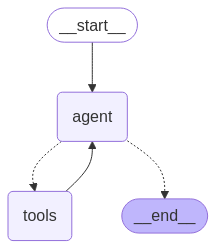

In [6]:
#5

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

def create_langgraph(tools):

    def should_continue(state: GraphState):
        messages = state["messages"]
        last_message = messages[-1]
        if last_message.tool_calls:
            return "tools"
        return END

    def call_llm(state: GraphState):
        response = chain.invoke({"messages":state["messages"]})
        print("====response====")
        print(response)
        return {"messages": [response]}

    tool_node = ToolNode(tools)

    workflow = StateGraph(GraphState)
    workflow.add_node("agent", call_llm)
    workflow.add_node("tools", tool_node)

    workflow.add_edge(START, "agent")
    workflow.add_conditional_edges("agent", should_continue, ["tools", END])
    workflow.add_edge("tools", "agent")

    memory = MemorySaver()
    graph = workflow.compile(checkpointer=memory)
    return graph

graph = create_langgraph(tools)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
#6

while True:
    query = input("질문을 입력해주세요: ")
    if query.lower() in ["exit", "quit"]:
        print("종료하겠습니다.")
        break

    print("################# 질문 #################")
    print("질문:", query)

    input_query = [HumanMessage(
            [
                {
                    "type": "text",
                    "text": f"{query}"
                },
            ]
        )]

    response = graph.invoke({"messages": input_query} ,config={"configurable": {"thread_id": uuid.uuid4()}})

    print("response: ", response)
    print("################# 응답 #################")
    print("AI 응답",response["messages"][-1].content)




질문을 입력해주세요: 최신 동영상 생성 AI(오픈 모델) 중에 애니메이션풍의 동영상을 품질 높게 생성할 수 있는 모델을 조사해 주세요. 출력 시에는 정밀도에 대해 조사한 후 현시점에서 가장 고성능인 모델을 알려주세요. 또한 그 모델의 이용 방법 등에 대해서도 알고 싶습니다. 또 상용 이용이 가능한 라이선스로 좁혀주세요.
################# 질문 #################
질문: 최신 동영상 생성 AI(오픈 모델) 중에 애니메이션풍의 동영상을 품질 높게 생성할 수 있는 모델을 조사해 주세요. 출력 시에는 정밀도에 대해 조사한 후 현시점에서 가장 고성능인 모델을 알려주세요. 또한 그 모델의 이용 방법 등에 대해서도 알고 싶습니다. 또 상용 이용이 가능한 라이선스로 좁혀주세요.
====response====
content="네, 최신 오픈 소스 동영상 생성 AI 모델 중 애니메이션풍의 고품질 동영상을 생성할 수 있고 상용 이용이 가능한 모델에 대해 조사해 보겠습니다.\n\n이 분야는 매우 빠르게 발전하고 있으며, '최고 성능'은 기준이나 사용 방법에 따라 달라질 수 있습니다. 현재 시점에서 애니메이션 스타일에 특히 강점을 보이거나 해당 스타일 구현에 널리 사용되는 오픈 소스 기술을 중심으로 찾아보겠습니다.\n\n`tavily_search_tool`을 사용하여 관련 정보를 검색하겠습니다." additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"search_depth": "advanced", "time_range": "year", "query": "latest open source video generation AI anime high quality commercial use"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP